In [1]:
import easyocr
import re
import cv2
from tqdm.notebook import tqdm
from datetime import datetime
from tools.frame_detector import FrameDetector, Frame
from matplotlib import pyplot as plt
import matplotlib.patches as patches


In [2]:
file_name = "test/samples/sample_episode.mp4"
vidcap = cv2.VideoCapture(file_name)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS)
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
h, w, _ = image.shape


In [3]:
frames = {}

pbar = tqdm(total=frame_count)
count = 0
while(success):
    if count % (2 * fps) == 0:  # every 2 seconds
        success, image = vidcap.read()

        # get frame timestamp
        timestamp = vidcap.get(cv2.CAP_PROP_POS_MSEC) / 1000
        timestamp = datetime.fromtimestamp(timestamp).strftime('%M:%S')
        
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            frames[timestamp] = image[h//2:h, w//2:w]

    else:
        ret = vidcap.grab()
    count += 1
    # pbar.update(1)
# pbar.close()

  0%|          | 0/77932 [00:00<?, ?it/s]

results are at:
  * 2:54 - 2:56
  * 13:29 - 13:31
  * 25:33 - 25:36
  * 34:47 - 34:50
  * 45:46 - 45:48

In [4]:
detector = FrameDetector(frames)
detector.detect()
best = detector.get_best_results()


100%|██████████| 1559/1559 [01:40<00:00, 15.56it/s]


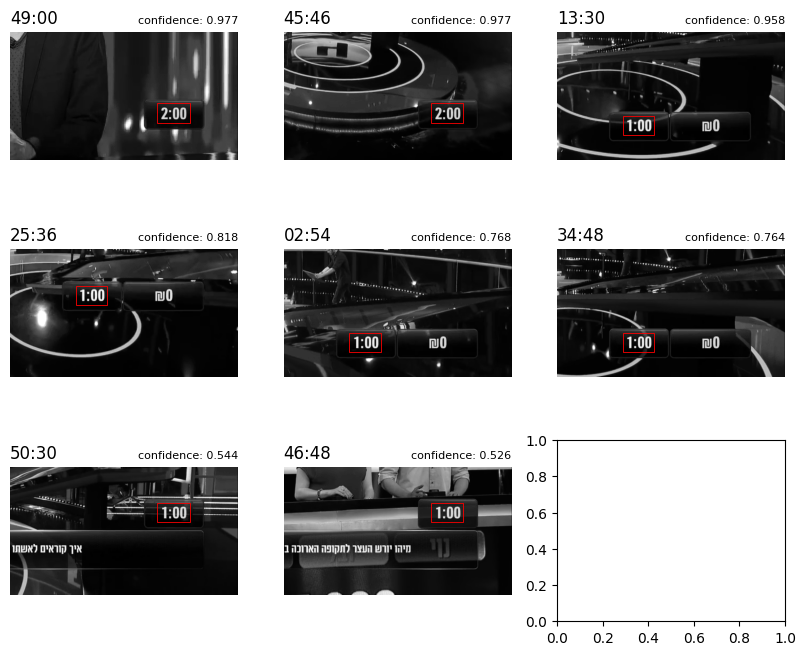

In [11]:
def show(frmaes):
    fig, axs = plt.subplots((len(frmaes) + 1) // 3, 3, figsize=(10,8))
    axs = axs.flatten()
    for i, frame in enumerate(frmaes):
        x1, y1 = frame.rect[0]
        x2, y2 = frame.rect[2]
        w, h = x2 - x1, y2 - y1
        axs[i].axis('off')   
        axs[i].set_title(f"{frame.stamp}", loc="left")
        axs[i].set_title("confidence: {:.3}".format(frame.confidence), fontsize=8, loc="right")
        rect = patches.Rectangle((x1 - 5, y1 - 5), w + 5, h + 5, linewidth=0.6, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)
        axs[i].imshow(frames[frame.stamp], cmap="gray")

show(best)

In [6]:
vidcap.release()